# Big Data Bandits

A Project-Group of the DHBW Karlsruhe participating in a AI-powerd World.

# In wie weit ist Marktmanipulation durch Privatpersonen auf Sozialmedia möglich?

Im folgenden Abstract soll dieser Frage nachgegangen werden.
Dafür betrachten wir insbesondere die Beziehungen zwischen dem Aktienkurs der Kryptowährung **Dogecoin (DGCN)**, sowie dem Nutzungsverhalten von **Elon Musk** auf der Plattform **X** (ehemalig Twitter).
Dabei ist uns natürlich bewusst, dass Elon Musk aufgrund seiner Reichweite und Popularität eine sehr dominate und übergeordnete Rolle spielt. Jedoch zeigt genau dieses Beispiel interresante und unerwartete Zusammenhänge.

Zu Beginn der Analyse werden die Datensätzte in einen Pandas Dataframe eingelsesen.

In [201]:
import pandas as pd

from datetime import datetime
dateparse = lambda x: datetime.strptime(x[0:10], '%Y-%m-%d')

#Read the CSV files and put them into pandas DataFrame objects
Posts:pd.DataFrame = pd.read_csv('./datasets/elonmusk.csv', parse_dates=['datetime'], date_parser=dateparse)
Tesla:pd.DataFrame = pd.read_csv('./datasets/tesla.csv', parse_dates=['date'], date_parser=dateparse)
Dogecoin:pd.DataFrame = pd.read_csv('./datasets/dogecoin.csv', parse_dates=['date'], date_parser=dateparse)

C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_8056\2570140147.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  Posts:pd.DataFrame = pd.read_csv('./datasets/elonmusk.csv', parse_dates=['datetime'], date_parser=dateparse)
C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_8056\2570140147.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  Tesla:pd.DataFrame = pd.read_csv('./datasets/tesla.csv', parse_dates=['date'], date_parser=dateparse)
C:\Users\ZODWEISS\AppData\Local\Temp\ipykernel_8056\2570140147.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then c

Im Weiteren definieren wir ein paar Hilfsfunktionen, die uns kleinere Nebenberechnungen im Verlauf der Analyse abnehmen.  
So berechnet z.B.: die Funktion **get_trade_day_avg()** den Durchschnittlichen Handelspreis einer Aktie für einen bestimmten Tag. 

In [202]:
import datetime
import pandas as pd

def check_filter(text:str, filter_list:list, hit:bool):
    for filter in filter_list:
        if filter in text:
            return hit
    return not hit

def get_interval(search_date:datetime, stock:pd.DataFrame, interval_length:int=5):
    next_available_date = stock.loc[stock['date'] >= search_date, 'date'].min()
    start_index = stock[stock['date'] == next_available_date].index[0]
    end_index = start_index + interval_length

    if end_index > stock.index[-1]:
        return None
    else:
        return stock.iloc[start_index:end_index]

Die nachfolgende Funktion **get_trend()** ist ein wichtiges Kernstück der Analyse. Denn diese Funktion ermittelt mit Hilfe einer linearen Regression eine Gerade, welche das Wachstum einer Aktie für einem gegebenen Zeitraum repräsentiert. Standart ist hierbei ein Zeitraum von 5 Tagen.

In [203]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def get_absolute(stock_part:pd.DataFrame):
    initial = stock_part.iloc[0]["close"]
    final = stock_part.iloc[-1]["close"]
    return (final - initial) / abs(initial) * 100

def get_trend(stock_part:pd.DataFrame):
    colses_of_interval:list = stock_part["close"].tolist()
    
    x = np.array(range(len(colses_of_interval))).reshape(-1, 1)
    y = np.array(colses_of_interval)

    model = LinearRegression().fit(x, y)

    x_first = np.array([0]).reshape(-1, 1)
    x_last = np.array([len(colses_of_interval) - 1]).reshape(-1, 1)

    y_first = model.predict(x_first)[0]
    y_last = model.predict(x_last)[0]

    change_percentage = round((y_last / y_first), 4)

    return [change_percentage, model]

In [204]:
def get_influences(stock:pd.DataFrame, Posts:pd.DataFrame=Posts, filter_list:list=[], hit:bool=False,):
    influences:pd.DataFrame = pd.DataFrame(columns=['date', 'posts', 'count_posts', 'trend', 'absolute'])
    j = 0
    old_date = None
    
    for i, Post in Posts.iterrows():
        if not check_filter(str(Post['text']), filter_list, hit=hit):
            continue
        else:
            date = pd.to_datetime(Post['datetime']).normalize()
            
            if not date == old_date:
                interval = get_interval(date, stock)

                if interval is None:
                    print("No Data Available")
                    continue

                cp_trend, model = get_trend(interval)
                cp_absolute = get_absolute(interval)
                influences.loc[j] = [date] + [[Post['text']]] + [0] + [cp_trend] + [cp_absolute]
                old_date = date
                j += 1

            else:
                influences.loc[j-1, 'posts'].append(Post['text'])
                influences.loc[j-1, 'count_posts'] += 1
    return [influences, j/i*100]


In [205]:
influences_n_d, part_n_d = get_influences(Dogecoin, Posts, ["dodgecoin", "Dodgecoin", "dodge", "coin"], False)
influences_w_d, part_w_d = get_influences(Dogecoin, Posts, ["dodgecoin", "Dodgecoin", "dodge", "coin"], True)

influences_n_t, part3 = get_influences(Tesla, Posts, ["Tesla", "Car"], False)
influences_w_t, part4 = get_influences(Tesla, Posts, ["Tesla", "Car"], True)

influences_t_d, partM1 = get_influences(Dogecoin, Posts, [], False)
influences_t_t, partM2 = get_influences(Tesla, Posts, [], False)

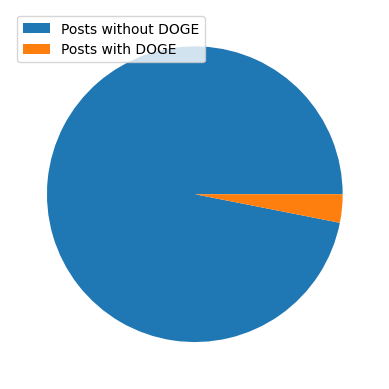

In [218]:
import matplotlib.pyplot as plt
plt.pie([part_n_d, part_w_d])
plt.legend(labels=["Posts without DOGE", "Posts with DOGE"], loc="upper left")

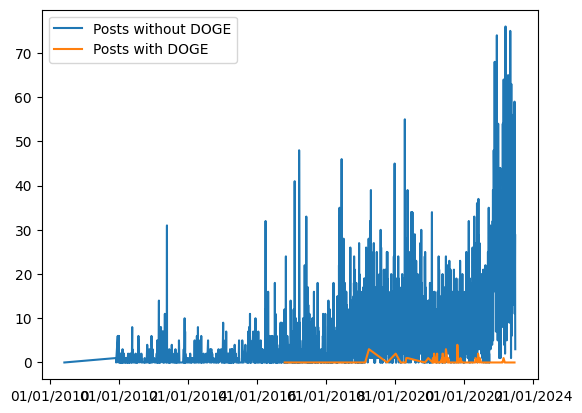

In [219]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences_n_d['date'], influences_n_d['count_posts'])
plt.plot(influences_w_d['date'], influences_w_d['count_posts'])
plt.legend(labels=["Posts without DOGE", "Posts with DOGE"], loc="upper left")

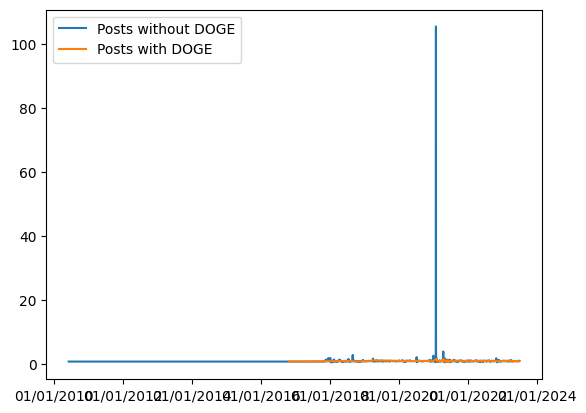

In [220]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences_n_d['date'], influences_n_d['trend'])
plt.plot(influences_w_d['date'], influences_w_d['trend'])
plt.legend(labels=["Posts without DOGE", "Posts with DOGE"], loc="upper left")

<BarContainer object of 2 artists>

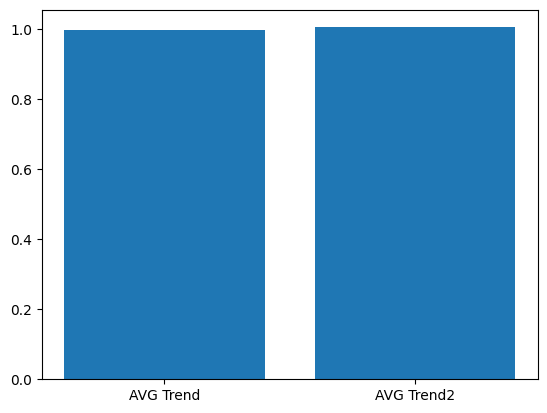

In [237]:
import matplotlib.pyplot as plt

plt.bar(["AVG Trend without DOGE", "AVG Trend with DOGE"], [influences_n_d.loc[:, 'trend'].mean(), influences_w_d.loc[:, 'trend'].mean()])

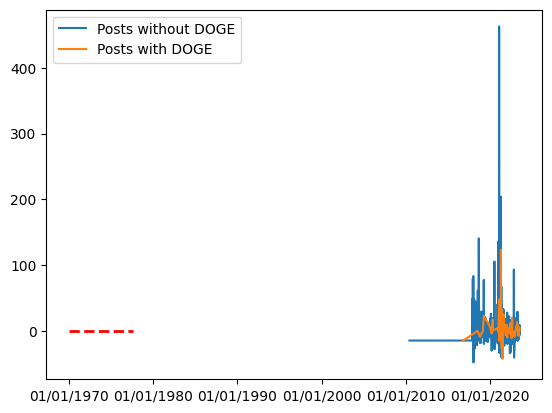

In [245]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences_n_d['date'], influences_n_d['absolute'])
plt.plot(influences_w_d['date'], influences_w_d['absolute'])
plt.legend(labels=["Posts without DOGE", "Posts with DOGE"], loc="upper left")

<BarContainer object of 2 artists>

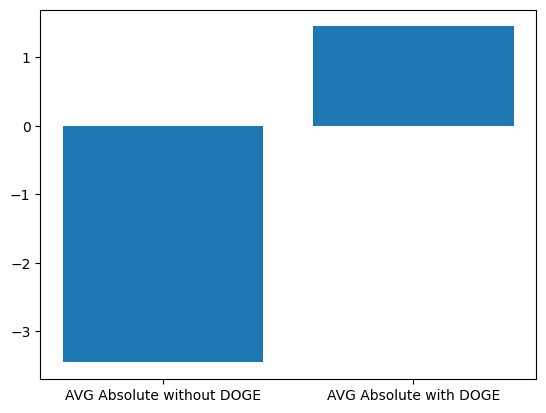

In [246]:
import matplotlib.pyplot as plt

plt.bar(["AVG Absolute without DOGE", "AVG Absolute with DOGE"], [influences_n_d.loc[:, 'absolute'].mean(), influences_w_d.loc[:, 'absolute'].mean()])